[図2-1](http://localhost:8888/notebooks/pywork/ROC/ROC-curve-explanation.ipynb#図2-1)  
[図2-2](http://localhost:8888/notebooks/pywork/ROC/ROC-curve-explanation.ipynb#図2-2)  
[図2-3](http://localhost:8888/notebooks/pywork/ROC/ROC-curve-explanation.ipynb#図2-3)  
[図2-4](http://localhost:8888/notebooks/pywork/ROC/ROC-curve-explanation.ipynb#図2-4)  

In [1]:
import math, sys, functools, os, glob, sqlite3
import numpy as np
import numpy.random as rd
from numpy import matrix
import pandas as pd
import scipy as sp
from scipy import stats as st
from datetime import  datetime as dt
from collections import Counter
from itertools import chain
import multiprocessing as mp

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
%matplotlib inline

import  pickle
def unpickle(filename):
    with open(filename, 'rb') as fo:
        p = pickle.load(fo)
    return p

def to_pickle(filename, obj):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, -1)

from matplotlib.colors import LinearSegmentedColormap

def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

cm = generate_cmap(['lightblue', 'mediumblue', 'mediumblue','black', 'red', 'red', 'orangered'])

from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets

import rpy2
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from rpy2.robjects.functions import SignatureTranslatedFunction

# import pandas.rpy.common as com   # [depricated]
from rpy2.robjects import pandas2ri
pandas2ri.activate()

pd.options.display.max_rows = 71


from scipy import interp

from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import gaussian_process

from sklearn import cross_validation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve
from sklearn.preprocessing import Imputer

from sklearn.grid_search import GridSearchCV

import xgboost as xgb

from sklearn.externals.six import StringIO  
import pydot

from IPython.display import Image 
import matplotlib.font_manager as fm
#fm.findSystemFonts()
plt.rcParams['font.family'] = 'Osaka'

def find_col_idx(df, name):
    """指定したnameが何番目のカラムかを返す"""
    key = df.keys()
    key_list = list(key)
    return key_list.index(name)

def fill_na_average(df, col_name_list):
    """NAの値はその平均値で埋める。"""
    for name in col_name_list:
        df[name] = df[name].fillna(df[name].mean())


# カテゴリ変数をダミー変数化
def convert_dummies(df, key, rm_first=False):
    
    dum = pd.get_dummies(df[key])
    ks = dum.keys()
    dum.columns = [key + "_" + str(k) for k in ks]
    
    # 先頭の値の列を削除する
    if rm_first:
        # partial法として最初の値を基準群とする
        print("Removing {} from {}...".format(ks[0], key))
        df = pd.concat((df, dum.ix[:,1:]), axis=1)
    else:
        
        df = pd.concat((df, dum), axis=1)
        
    df = df.drop(key, axis=1)
    return df        
        
def show_evaluation(cls, X_train, y_train, X_test, y_test, pred, pred_test, target_names):
    print("====== train ======")
    print(cls.score(X_train, y_train))
    print(classification_report(y_train, pred, target_names=target_names))
    print(confusion_matrix(y_train, pred))
    print("Accuracy", accuracy_score(y_train, pred))

    print("====== test ======")
    print(cls.score(X_test, y_test))
    print(classification_report(y_test, pred_test, target_names=target_names))
    print(confusion_matrix(y_test, pred_test))
    print("Accuracy", accuracy_score(y_test, pred_test))

# Learning Curveの描画
def draw_learning_curve(clf, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), ymin=0.9, ymax=1.0):
    train_sizes, train_scores, test_scores =\
                learning_curve(estimator=clf,
                               X=X_train,
                               y=y_train,
                               train_sizes=train_sizes,
                               cv=10,
                               n_jobs=1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(12,6))
    plt.plot(train_sizes, train_mean, lw=1,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    #plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([ymin, ymax])
    plt.title("Learning Curve")
    plt.tight_layout()
    # plt.savefig('./figures/learning_curve.png', dpi=300)
    plt.show()
    

def draw_validation_curve(clf, X, y, param_name, param_range, ymin=0.8, ymax=1.0):
    train_scores, test_scores = validation_curve(
                    estimator=clf, 
                    X=X_resampled, 
                    y=y_resampled, 
                    param_name=param_name, 
                    param_range=param_range,
                    cv=10)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(12,6))
    plt.plot(param_range, train_mean, 
             color='blue', marker='o', 
             markersize=5, label='training accuracy')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color='blue')

    plt.plot(param_range, test_mean, 
             color='green', linestyle='--', 
             marker='s', markersize=5, 
             label='validation accuracy')

    plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color='green')

    #plt.grid()
    plt.legend(loc='best')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.ylim([ymin, ymax])
    plt.title("Validation Curve")
    plt.tight_layout()
    plt.show()
    

def draw_ROC(clf, X, y, n_fold=5, test_size=0.33, random_state=0):
    
    cv = StratifiedShuffleSplit(y, n_fold, test_size=test_size, random_state=random_state)

    fig = plt.figure(figsize=(7, 5))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    plt.figure(figsize=(10,6))
    for i, (train, test) in enumerate(cv):
        probas = clf.fit(X[train], y[train]).predict_proba(X[test])

        fpr, tpr, thresholds = roc_curve(y[test], probas[:, 1],  pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr,
                 tpr,
                 lw=1,
                 label='ROC fold %d (area = %0.2f)'
                       % (i+1, roc_auc))

    plt.plot([0, 1],
             [0, 1],
             linestyle='--',
             color=(0.6, 0.6, 0.6),
             label='random guessing')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.plot([0, 0, 1],
             [0, 1, 1],
             lw=2,
             linestyle=':',
             color='black',
             label='perfect performance')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('Receiver Operator Characteristic')
    plt.legend(loc="lower right")
    plt.tight_layout()
    # plt.savefig('./figures/roc.png', dpi=300)
    plt.show()

/Users/matsuken/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:

from matplotlib import animation as ani
import sklearn.metrics as mt

In [3]:
def sigmoid(x, a=1, b=0):
    return 1 / (1 + np.exp(-a*x+b))

In [4]:
rs = 72
xn = st.norm.rvs(size=20, loc=0, scale=1, random_state=rs)
xp = xn
#xp = st.norm.rvs(size=20, loc=2.3, scale=1, random_state=rs)

# 図3-1

In [ ]:

# Fixed parameter

xmin, xmax = -4, 2
a, b = 3, -.5
xx = np.linspace(xmin, xmax, 201)
y = sigmoid(xx, a=a,b=b)

tpr_list = []
fpr_list = []
f_val_list = []
num_frame = 101
xxx = np.linspace(xmin, xmax, num_frame)[::-1]

for i, thresh in enumerate(xxx):
    col_n = list(map(lambda x: "b" if x<= thresh else "r", xn))
    col_p = list(map(lambda x: "b" if x>= thresh else "r", xp))
    
    tpr = col_p.count("b") / len(xp)
    fpr = col_n.count("r") / len(xn)
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    
    p = sigmoid(thresh, a=a,b=b)

    # Graph Drawing
    plt.figure(figsize=(14,10))
    
    plt.subplot(221) #==============================================================================
    plt.plot([thresh,thresh], [-0.2, 1.2], "k", lw=1)
    plt.plot([xmin, xmax], [p, p], "k--", lw=.5)
    plt.plot(xx, y, color="g", lw=2) # sigmoid curve
    plt.scatter(xn, [0]*len(xn), marker="o", color=col_n, s=50, zorder=100)
    plt.scatter(xp, [1]*len(xp), marker="x", color=col_p, s=50, zorder=100, linewidth=2)
    
    plt.text(5, .98, "真陽性", size=12)
    plt.text(5, -.02, "真陰性", size=12)
    
    if thresh >= -2:
        plt.text(thresh-1, .78, "陰性と判断←", size=12 )
    
    plt.text(thresh+.1, .18, "→陽性と判断", size=12 )
    
    plt.title("threshold:{0:.3f}, p:{1:.3f}, tpr:{2:.3f}, fpr:{3:.3f}".format(thresh, p, tpr, fpr))

    plt.ylim(-0.2, 1.2)
    plt.xlim(xmin, xmax)
    
    # 凡例用
    plt.scatter([-10],[-10], marker="o", color="r",  s=50, label="False Negative")
    plt.scatter([-10],[-10], marker="o", color="b",  s=50, label="True Positive")
    
    plt.scatter([-10],[-10], marker="x", color="r",  s=50, linewidth=2, label="False Positive")
    plt.scatter([-10],[-10], marker="x", color="b",  s=50, linewidth=2, label="True Negative")
    
    plt.legend(loc="upper left", )
    
    
    plt.subplot(224) #==============================================================================
    plt.plot(fpr_list, tpr_list)
    plt.scatter(fpr_list, tpr_list)
    plt.plot([0,1],[0,1], "k--", lw=1)
    
    plt.xlim(-.01,1.01)
    plt.ylim(-.01,1.01)
    
    plt.ylabel("←悪い            良い→")
    plt.xlabel("←良い            悪い→")
    
    plt.subplot(223) #==============================================================================
    
    if col_p.count("b")+col_n.count("r") != 0:
        precision = col_p.count("b")/(col_p.count("b")+col_n.count("r"))
    else:
        precision = 0
        
    recall = tpr
    
    if precision+recall != 0:
        f_value = 2 / (1/precision + 1/recall)
    else:
        f_value = 0
    
    f_val_list.append(f_value)
    
    plt.plot(xxx[:len(f_val_list)], f_val_list)
    plt.scatter(xxx[:len(f_val_list)], f_val_list)
    plt.title("f-value")
    plt.ylim(-0.2, 1.2)
    plt.xlim(xmin, xmax)
    
    plt.tight_layout()
    plt.savefig("./img/ROC_rd_{0:02d}".format(i+1), dpi=128)
    #plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 276


# 図2-4

51
0%, 0%, 1%, 3%, 5%, 7%, 9%, 11%, 13%, 15%, 17%, 19%, 21%, 23%, 25%, 27%, 29%, 31%, 33%, 35%, 37%, 39%, 41%, 43%, 45%, 47%, 49%, 50%, 52%, 54%, 56%, 58%, 60%, 62%, 64%, 66%, 68%, 70%, 72%, 74%, 76%, 78%, 80%, 82%, 84%, 86%, 88%, 90%, 92%, 94%, 96%, 98%, 0%, 

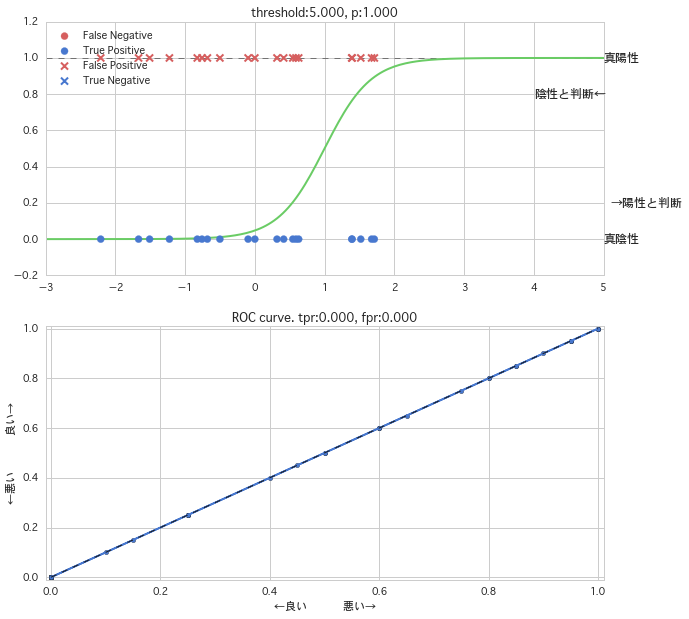

In [9]:

# Fixed parameter
xmin, xmax = -4, 2
a, b = 3, -.5
xx = np.linspace(xmin, xmax, 201)
y = sigmoid(xx, a=a,b=b)

def animate(nframe):
    global num_frame, tpr_list, fpr_list
    sys.stdout.write(str(int(float(nframe)/num_frame*100)) + "%, ") 
    
    thresh = np.linspace(xmin, xmax, num_frame)[::-1][nframe]
    
    col_n = list(map(lambda x: "b" if x<= thresh else "r", xn))
    col_p = list(map(lambda x: "b" if x>= thresh else "r", xp))

    tpr = col_p.count("b") / len(xp)
    fpr = col_n.count("r") / len(xn)
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    
    p = sigmoid(thresh, a=a,b=b)

    # Graph Drawing
    plt.clf()
    plt.subplot(211)
    #plt.figure(figsize=(10,5))
    plt.plot([thresh,thresh], [-0.2, 1.2], "k", lw=1)
    plt.plot([xmin, xmax], [p, p], "k--", lw=.5)
    plt.plot(xx, y, color="g", lw=2) # sigmoid curve
    plt.scatter(xn, [0]*len(xn), marker="o", color=col_n, s=50, zorder=100)
    plt.scatter(xp, [1]*len(xp), marker="x", color=col_p, s=50, zorder=100, linewidth=2)
    
    plt.text(5, .98, "真陽性", size=12)
    plt.text(5, -.02, "真陰性", size=12)
    
    if thresh >= -2:
        plt.text(thresh-1, .78, "陰性と判断←", size=12 )
    
    plt.text(thresh+.1, .18, "→陽性と判断", size=12 )
    
    plt.title("threshold:{0:.3f}, p:{1:.3f}".format(thresh, p))

    plt.ylim(-0.2, 1.2)
    plt.xlim(xmin, xmax)
    
    # 凡例用
    plt.scatter([-10],[-10], marker="o", color="r",  s=50, label="False Negative")
    plt.scatter([-10],[-10], marker="o", color="b",  s=50, label="True Positive")
    
    plt.scatter([-10],[-10], marker="x", color="r",  s=50, linewidth=2, label="False Positive")
    plt.scatter([-10],[-10], marker="x", color="b",  s=50, linewidth=2, label="True Negative")
    
    plt.legend(loc="upper left", )

    plt.subplot(212)
    plt.plot(fpr_list, tpr_list)
    plt.scatter(fpr_list, tpr_list)
    plt.plot([0,1],[0,1], "k--", lw=1)
    
    plt.xlim(-.01,1.01)
    plt.ylim(-.01,1.01)
    
    plt.ylabel("←悪い            良い→")
    plt.xlabel("←良い            悪い→")
    
    plt.title("ROC curve. tpr:{0:.3f}, fpr:{0:.3f}".format(tpr, fpr))
    
num_frame = 51
tpr_list = []
fpr_list = []

fig = plt.figure(figsize=(10,10))

print(num_frame)
anim = ani.FuncAnimation(fig, animate, frames=num_frame, blit=False)

anim.save('Logis2_rd.gif', writer='imagemagick', fps=3, dpi=64)